CS470 Assignment #1: CNN classification with Cifar10
====

Primary TA : Myeongjae Jang

TA's E-mail : myeongjae0409@kaist.ac.kr

## Instruction

- Modify the baseline CNN model to improve the classification performance on Cifar10 dataset. In addition to the model definition, you can modify any parts of this colab example to improve the test accuracy (e.g., learning rate, batch size, etc.)
- Train your CNN model and compare it to the baseline (in terms of training loss and the test accuracy).
- Explain your modifications and discuss how you improved the test accuracy.

## Submission guidelines

- Your code and report will be all in Colab. Copy this example to your google drive and edit it to complete your assignment. Add sections at the bottom of this example to discuss the results. For discussion and analysis, we highly encourage you to use graphics if possible (e.g., plots, images, etc.). 
- To make grading efficient, please highlight all contributions & modifications you made clearly. We highly encourage you to add code blocks in the discussion section to discuss your modifications (e.g., you can describe the model definition in the discussion section using the code blocks).
- We should be able to reproduce your results using your code and pre-trained model. Please double-check if your code runs without error and loads your pre-trained model properly. Submissions failed to run or reproduce the results will get a substantial penalty. 
- In this assignment, **we are not allowing fine-tuning from the pre-trained model** (e.g. ImageNet pre-trained models). You should train your  model on Cifar10 dataset from scratch. 

## Deliverables
- Download your Colab notebook and the pre-trained model, and submit a zip file in a format: [StudentID].zip. Please double-check that you locate and load your pre-trained model properly.
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions. 

## Grading policy

- **Code** (50%): Your code should work and outperform the baseline model in terms of the test accuracy. 
- **Report** (50%): Explain your modification and justify how it improved the perofrmance. It would be great if you have some supporting results for your justification (e.g., justifying that you resolved the overfitting by comparing two training/testing loss curves). 
- **Extra points** will be given if your submission satisfies the following:
 - **High test accuracy**: we will rank the submissions based on the test accuracy, and assign extra points according to the rank (e.g. 3 points for top 10%, 2 points for top 30%, 1 points for top 50%.)
 - **Comprehensive discussion**: we will assign extra points if your report contains comprehensive discussion/analysis of the results. Examples include justification of your choice of model (or hyper-parameters), comparisons to the baseline model (analysis on the source of improvement), insightful visualizations (loss curves, misclassification results), etc.

## Due date
- **23:59:59 September 25th.**
- Late submission is allowed until 23:59:59 September 27th.
- Late submission will be applied 20% penalty.

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Assignment 1]" in the subject for all questions regarding this assignment (e.g., [Assignment 1] Regarding the grading policy).

## PyTorch Documentation
- You can refer PyTorch documentation for your assignment.
- https://pytorch.org/docs/stable/index.html



## Step 1: Connect to your Google Drive

It is required if you want to save checkpoints and load them later on.

### (You have to submit your trained results as the checkpoint. So, please check your Google Drive connection again.)

In [1]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Step 2: Import modules

In [2]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

!pip install -U tensorboardcolab
from tensorboardcolab import TensorBoardColab

torch.manual_seed(470)
torch.cuda.manual_seed(470)

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


Using TensorFlow backend.


## Step 3: Configure the experiments

In [3]:
# training & optimization hyper-parameters
max_epoch = 450
learning_rate = 0.1
batch_size = 128
device = 'cuda'

# model hyper-parameters
output_dim = 10 

# Boolean value to select training process
training_process = True

# initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://6d53fc21.ngrok.io


## Step 4: Construct data pipeline

**`torchvision.datasets.CIFAR10`** will automatically construct **`Cifar10`** dataset.

In [4]:
data_dir = os.path.join(gdrive_root, 'my_data')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Step 5: Construct a neural network builder

We serve the baseline CNN model which is supported on Pytorch tutorial: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=c1E1b7-igUcR

### (You have to compare your own CNN model's test accuracy with the baseline CNN model and explain why your own model's test accuracy is higher than the basline.)

In [0]:
class MyClassifier(nn.Module):
  def __init__(self):
        super(MyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.batchnorm1 = nn.BatchNorm2d(num_features=6)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1)
        self.fc1 = nn.Linear(in_features=64 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=output_dim)

  def forward(self, x):
      x = self.pool(self.relu(self.batchnorm1(self.conv1(x))))
      x = self.pool(self.relu(self.conv2(x)))
      x = self.pool(self.relu(self.batchnorm3(self.conv3(x))))
      x = self.pool(self.relu(self.conv4(x)))
      x = x.view(-1, 64 * 1 * 1)
      x = self.relu(self.fc1(x))
      outputs = self.fc2(x)
      return outputs

# VGG19 Model

In [0]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = self._make_layers([64, 64, 'Pool', 128, 128, 'Pool', 256, 256, 256, 256, 'Pool', 512, 512, 512, 512, 'Pool', 512, 512, 512, 512, 'Pool'])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'Pool':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

## Step 6: Initialize the network and optimizer


In [7]:
#my_classifier = MyClassifier()
my_classifier = VGG()
my_classifier = my_classifier.to(device)
if device == 'cuda':
    my_classifier = torch.nn.DataParallel(my_classifier)
    cudnn.benchmark = True
# Print your neural network structure
print(my_classifier)

#optimizer = optim.Adam(my_classifier.parameters(), lr=learning_rate)
optimizer = optim.SGD(my_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)


DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

# Schedule learning rate

In [0]:
from torch.optim.lr_scheduler import MultiStepLR 

scheduler = MultiStepLR(optimizer, milestones=[150,300], gamma=0.1)


## Step 7: Load pre-trained weights if exist

- **For your sumbmission you have to store the trained model as a checkpoint.**
- Please do not erase this step.
- If you want to modify this step, please be careful.
- After training please confirm that your checkpoint is correctly stored and re-loaded.

In [0]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_acc = 0.
ckpt_path = os.path.join(ckpt_dir, 'lastest_vgg_final.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    my_classifier.load_state_dict(ckpt['my_classifier'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_acc = ckpt['best_acc']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best accuracy : %.2f' % best_acc)


## Step 8: Train the network

Note : It would be better to save checkpoints periodically, otherwise you'll lose everything you've trained if the session is recycled.

In [0]:
cross_entropy = nn.CrossEntropyLoss()

if training_process:
  it = 0
  train_losses = []
  test_losses = []
  for epoch in range(max_epoch):
    scheduler.step()
    # train phase
    my_classifier.train()
    for inputs, labels in train_dataloader:
      it += 1

      # load data to the GPU.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # feed data into the network and get outputs.
      logits = my_classifier(inputs)

      # calculate loss
      # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
      #loss = F.cross_entropy(logits, labels)

      #Since I use VGG model and there is Linear Layer in the end, using nn.CrossEntropyLoss is more convenient
      loss = cross_entropy(logits, labels)

      # Note: You should flush out gradients computed at the previous step before computing gradients at the current step. 
      #       Otherwise, gradients will accumulate.
      optimizer.zero_grad()

      # backprogate loss.
      loss.backward()

      # update the weights in the network.
      optimizer.step()

      # calculate accuracy.
      acc = (logits.argmax(dim=1) == labels).float().mean()

      if it % 250 == 0:
        tbc.save_value('Loss', 'train_loss', it, loss.item())
        print('[epoch:{}, iteration:{}] train loss : {:.4f} train accuracy : {:.4f}'.format(epoch, it, loss.item(), acc.item()))

    # save losses in a list so that we can visualize them later.
    train_losses.append(loss)  

    # test phase
    n = 0.
    test_loss = 0.
    test_acc = 0.
    my_classifier.eval()
    for test_inputs, test_labels in test_dataloader:
      test_inputs = test_inputs.to(device)
      test_labels = test_labels.to(device)

      logits = my_classifier(test_inputs)
      #loss = cross_entropy(logits, test_labels, reduction='sum')
      test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
      #loss = nn.CrossEntropyLoss(logits, test_labels, False)
      #test_loss += loss.item()
      test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
      n += test_inputs.size(0)

    test_loss /= n
    test_acc /= n
    test_losses.append(test_loss)
    tbc.save_value('Loss', 'test_loss', it, test_loss)
    print('[epoch:{}, iteration:{}] test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch, it, test_loss, test_acc)) 

    tbc.flush_line('train_loss')
    tbc.flush_line('test_loss')

    # save checkpoint whenever there is improvement in performance
    if test_acc > best_acc:
      best_acc = test_acc
      # Note: optimizer also has states ! don't forget to save them as well.
      ckpt = {'my_classifier':my_classifier.state_dict(),
              'optimizer':optimizer.state_dict(),
              'best_acc':best_acc}
      torch.save(ckpt, ckpt_path)
      print('checkpoint is saved !')
    
tbc.close()



[epoch:0, iteration:250] train loss : 1.9856 train accuracy : 0.2031
[epoch:0, iteration:391] test_loss : 1.8244 test accuracy : 0.2631
checkpoint is saved !
[epoch:1, iteration:500] train loss : 1.7669 train accuracy : 0.2578
[epoch:1, iteration:750] train loss : 1.4269 train accuracy : 0.4297
[epoch:1, iteration:782] test_loss : 1.4724 test accuracy : 0.4369
checkpoint is saved !
[epoch:2, iteration:1000] train loss : 1.3464 train accuracy : 0.5391
[epoch:2, iteration:1173] test_loss : 1.2618 test accuracy : 0.5516
checkpoint is saved !
[epoch:3, iteration:1250] train loss : 0.9883 train accuracy : 0.6562
[epoch:3, iteration:1500] train loss : 0.9842 train accuracy : 0.6562
[epoch:3, iteration:1564] test_loss : 0.9819 test accuracy : 0.6652
checkpoint is saved !
[epoch:4, iteration:1750] train loss : 0.8734 train accuracy : 0.6328
[epoch:4, iteration:1955] test_loss : 1.0783 test accuracy : 0.6377
[epoch:5, iteration:2000] train loss : 0.8124 train accuracy : 0.7656
[epoch:5, itera

## Step 9: Visualize and analyze the results

In [0]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

if not training_process:
  # Re-load trained model
  my_classifier.load_state_dict(ckpt['my_classifier'])
  optimizer.load_state_dict(ckpt['optimizer'])

  # Testing
  n = 0.
  test_loss = 0.
  test_acc = 0.
  my_classifier.eval()
  for test_inputs, test_labels in test_dataloader:
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)

    logits = my_classifier(test_inputs)
    test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
    test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
    n += test_inputs.size(0)

  test_loss /= n
  test_acc /= n
  print('Test_loss : {:.4f}, Test accuracy : {:.4f}'.format(test_loss, test_acc))

In [0]:
import random

import matplotlib.pyplot as plt
import numpy as np

my_classifier.eval()

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)

test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(test_input))

# <font color="blue"> Discussion and Analysis </font>

<font color="blue"> 
Baseline model
---

</font>
<pre>
**Model Summary**
----------------------------------------------------------------  
        Layer (type)               Output Shape         Param #  
================================================================  
            Conv2d-1            [-1, 6, 28, 28]             456  
       BatchNorm2d-2            [-1, 6, 28, 28]              12  
              ReLU-3            [-1, 6, 28, 28]               0  
         MaxPool2d-4            [-1, 6, 14, 14]               0  
            Conv2d-5           [-1, 16, 12, 12]             880  
              ReLU-6           [-1, 16, 12, 12]               0  
         MaxPool2d-7             [-1, 16, 6, 6]               0  
            Conv2d-8             [-1, 32, 4, 4]           4,640  
       BatchNorm2d-9             [-1, 32, 4, 4]              64  
             ReLU-10             [-1, 32, 4, 4]               0  
        MaxPool2d-11             [-1, 32, 2, 2]               0  
           Conv2d-12             [-1, 64, 2, 2]           2,112  
             ReLU-13             [-1, 64, 2, 2]               0  
        MaxPool2d-14             [-1, 64, 1, 1]               0  
           Linear-15                   [-1, 64]           4,160  
             ReLU-16                   [-1, 64]               0  
           Linear-17                   [-1, 10]             650  
================================================================
Total params: 12,974  
Trainable params: 12,974  
Non-trainable params: 0  
----------------------------------------------------------------  
Input size (MB): 0.01  
Forward/backward pass size (MB): 0.17  
Params size (MB): 0.05  
Estimated Total Size (MB): 0.24  
----------------------------------------------------------------  

  After running the baseline model with given parameters, I got following results:  
  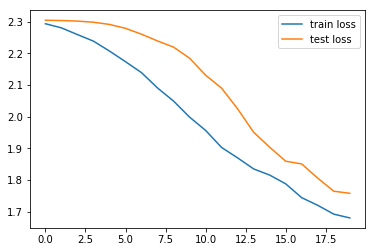![](https://drive.google.com/file/d/1Wx4uIGRCU5yEvLb4pvx8yW9eCeO1p_WI/view)

  It had 34.81% accuracy as well as 1.7583 test_loss.  
  I have realized that this training can go further, because test_loss was decreasing and since training was very fast (I observed that problem later), I increased max_epoch to 200. And as a result I got 59% accuracy and ~1.17 test_loss:

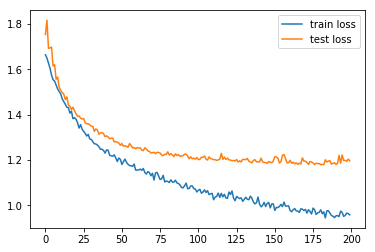![](https://drive.google.com/file/d/1aXrYUJUCtVSV4mzM5L7YC8jJYlFdBa_p/view)

  During hyperparameter tuning, I realised that it uses 3 iterations per epoch and they I saw that batch size is set to be 20000 which probably resulted in out of memory error. Therefore I set it to be 128. And since I increased the batch size, it would be resulted in more training time, therefore I reduced max_epoch to 100 to avoid to much training and overfitting. Beside of all those, I tried stochastic gradient descent optimizer instead of Adam: 
     
  ```
optimizer = optim.SGD(my_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4) 
  ```  
  After investigating more, I saw that in the data transformation, code uses wrong Normalization Values (it was very suspicious that normalization values are 0.5 in that mid-size dataset). Instead I searched on google and found correct values:

```
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
```

 
[Github code for calculating those values](https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py)  
  And after all these tunings, I ended up with 64% accuracy and 1.05 test_loss.
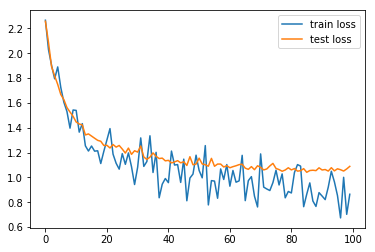![](https://drive.google.com/file/d/1zh_uaNK_XCffJFVtroalt1aBgEnSMZBx/view)

---
<font color="blue"> 
VGG model
---
</font>

**Model Summary**
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 128, 8, 8]               0
           Conv2d-15            [-1, 256, 8, 8]         295,168
      BatchNorm2d-16            [-1, 256, 8, 8]             512
             ReLU-17            [-1, 256, 8, 8]               0
           Conv2d-18            [-1, 256, 8, 8]         590,080
      BatchNorm2d-19            [-1, 256, 8, 8]             512
             ReLU-20            [-1, 256, 8, 8]               0
           Conv2d-21            [-1, 256, 8, 8]         590,080
      BatchNorm2d-22            [-1, 256, 8, 8]             512
             ReLU-23            [-1, 256, 8, 8]               0
           Conv2d-24            [-1, 256, 8, 8]         590,080
      BatchNorm2d-25            [-1, 256, 8, 8]             512
             ReLU-26            [-1, 256, 8, 8]               0
        MaxPool2d-27            [-1, 256, 4, 4]               0
           Conv2d-28            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-29            [-1, 512, 4, 4]           1,024
             ReLU-30            [-1, 512, 4, 4]               0
           Conv2d-31            [-1, 512, 4, 4]       2,359,808
      BatchNorm2d-32            [-1, 512, 4, 4]           1,024
             ReLU-33            [-1, 512, 4, 4]               0
           Conv2d-34            [-1, 512, 4, 4]       2,359,808
      BatchNorm2d-35            [-1, 512, 4, 4]           1,024
             ReLU-36            [-1, 512, 4, 4]               0
           Conv2d-37            [-1, 512, 4, 4]       2,359,808
      BatchNorm2d-38            [-1, 512, 4, 4]           1,024
             ReLU-39            [-1, 512, 4, 4]               0
        MaxPool2d-40            [-1, 512, 2, 2]               0
           Conv2d-41            [-1, 512, 2, 2]       2,359,808
      BatchNorm2d-42            [-1, 512, 2, 2]           1,024
             ReLU-43            [-1, 512, 2, 2]               0
           Conv2d-44            [-1, 512, 2, 2]       2,359,808
      BatchNorm2d-45            [-1, 512, 2, 2]           1,024
             ReLU-46            [-1, 512, 2, 2]               0
           Conv2d-47            [-1, 512, 2, 2]       2,359,808
      BatchNorm2d-48            [-1, 512, 2, 2]           1,024
             ReLU-49            [-1, 512, 2, 2]               0
           Conv2d-50            [-1, 512, 2, 2]       2,359,808
      BatchNorm2d-51            [-1, 512, 2, 2]           1,024
             ReLU-52            [-1, 512, 2, 2]               0
        MaxPool2d-53            [-1, 512, 1, 1]               0
        AvgPool2d-54            [-1, 512, 1, 1]               0
           Linear-55                   [-1, 10]           5,130
================================================================
Total params: 20,040,522
Trainable params: 20,040,522  
Non-trainable params: 0

Input size (MB): 0.01  
Forward/backward pass size (MB): 7.18  
Params size (MB): 76.45  
Estimated Total Size (MB): 83.64  

---

I looked up for the possible models and since our image size is 3x32x32, I decided to use VGGNet model, because it was easy to implement and it had much more parameters and layers and this  model could fix other parameters of the architecture, and steadily increase the depth of the network by adding more convolutional layers, which is feasible due to the use of very small (3×3) convolution filters in all layers. Due to the huge number of parameters, we can train this model more and avoid overfitting.

Because of I was using more complex model, I changed the hyperparameters and add some code to train it faster. All of the tunings and changes I have made (except implementation of VGG)


*   Despite of there is no significant difference in the performance between F.cross_entropy and nn.CrossEntropyLoss, I tried to use 2nd one. I succeeded to use in training process, however I could not achieve to use it on testing due to some errors. [Link](https://discuss.pytorch.org/t/f-cross-entropy-vs-torch-nn-cross-entropy-loss/25505)  
*   max_epoch = 450 (In the beginning, I trained model without lr_scheduler and noticed that after around 100 epochs, training and test loss does not improve anymore, therefore I decided to use lr_scheduler and therefore I increased the number of epochs to see the affect of scheduler)
learning_rate = 0.1 (In the beginning I wanted faster start and since I was using optimizer, it would not be problem)
batch_size = 128 (I did not have time for more than 128, because of 12 hours limit)
*  
```
if device == 'cuda':
my_classifier = torch.nn.DataParallel(my_classifier)
cudnn.benchmark = True
```
I added this line, because I felt that training is going very slow and after searching on google, I found [this](https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936)  and since input size was same, I decided to use and it made training slightly faster
*
```
from torch.optim.lr_scheduler import MultiStepLR 
scheduler = MultiStepLR(optimizer, milestones=[150,300], gamma=0.1)
```
This is probably the most important thing that affected to results. This code allows me to manually set learning rate during the training process without stopping the training and loading model again with new learning rate.

In the middle of training, I forgot to click on the page and I disconnected from server. First 160 epochs were trained until diconnection, then I loaded the model from checkpoint and trained rest of it.
First phase results:

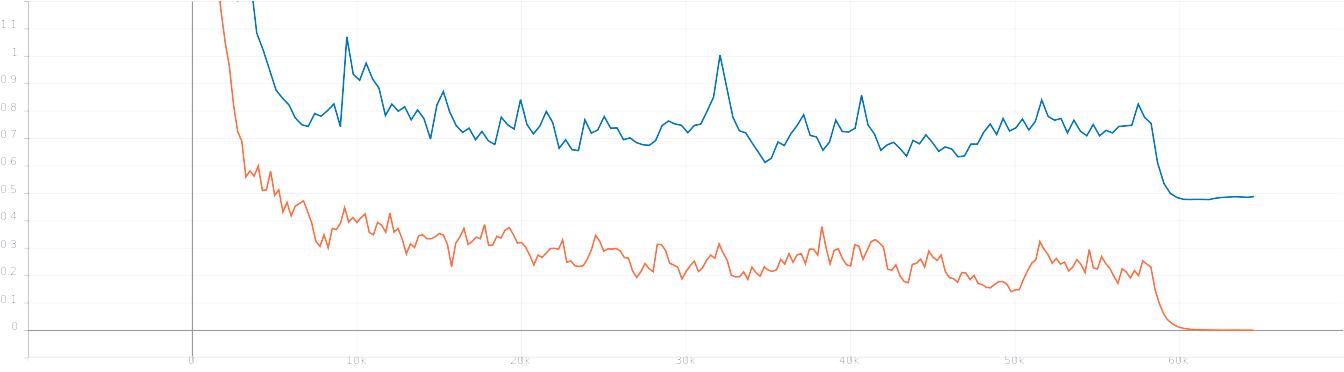



Second phase results :
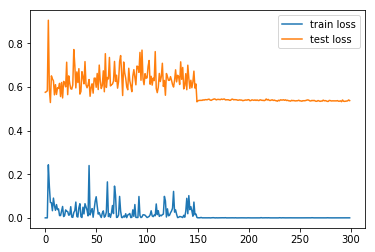

![](https://drive.google.com/file/d/1r--xWpkPpuwt2jatWb3ZkzbZ4PUbLYDB/view)
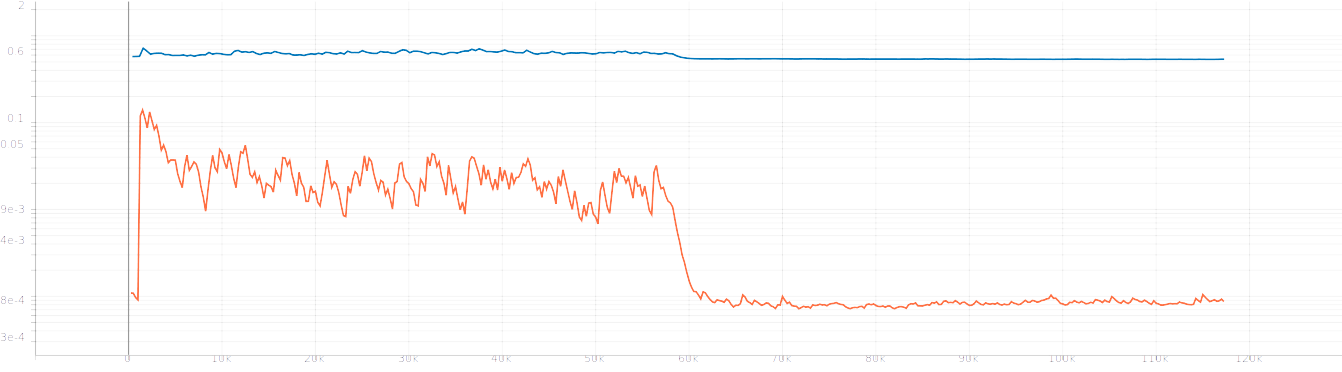

After training for more than 8 hours, I got 89.76% accuracy and test loss was ~0.53. 
From both of the graphs, it obvious that how learning rate scheduler improved our training:

[epoch:147, iteration:57500] train loss : 0.1708 train accuracy : 0.9219
[epoch:147, iteration:57750] train loss : 0.3390 train accuracy : 0.9141
[epoch:147, iteration:57868] test_loss : 0.6994 test accuracy : 0.7953
[epoch:148, iteration:58000] train loss : 0.2231 train accuracy : 0.9297
[epoch:148, iteration:58250] train loss : 0.2138 train accuracy : 0.9297
[epoch:148, iteration:58259] test_loss : 0.7224 test accuracy : 0.7870
[epoch:149, iteration:58500] train loss : 0.0212 train accuracy : 1.0000
[epoch:149, iteration:58650] test_loss : 0.3882 test accuracy : 0.8910
checkpoint is saved !
[epoch:150, iteration:58750] train loss : 0.0240 train accuracy : 0.9922
[epoch:150, iteration:59000] train loss : 0.0061 train accuracy : 1.0000
[epoch:150, iteration:59041] test_loss : 0.4165 test accuracy : 0.8931
checkpoint is saved !
[epoch:151, iteration:59250] train loss : 0.0023 train accuracy : 1.0000
[epoch:151, iteration:59432] test_loss : 0.4436 test accuracy : 0.8934
checkpoint is saved !

However, 2nd scheduling improved the training loss, it did not increase the accuracy and test loss did not decrease much.

Using SGD instead of Adam is my personal choice. Maybe Adam is better, but since I did not have time and because of 12 hours limit, I have to try it later on my own.

In order to improve the accuracy, we can use some data augmentation. I found transforms.RandomHorizontalFlip() (flips the picture) and transforms.RandomCrop() (crops some part of picture) functions that can be used in our train dataset for both improving accuracy and loss and giving ability to our model to predict flipped or shifted images. 

As we have seen that learning rate matters a lot, using Adam or Nesterov optimizer can also improve accuracy.
</pre>
